In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2021-03-02 08:41:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.199.80, 142.250.66.208, 142.250.66.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.199.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: '/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   110MB/s    in 1.3s    

2021-03-02 08:41:45 (110 MB/s) - '/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

['horse01-2.png', 'horse24-2.png', 'horse36-8.png', 'horse18-1.png', 'horse02-0.png', 'horse06-3.png', 'horse02-8.png', 'horse20-0.png', 'horse43-8.png', 'horse30-3.png']
['human04-28.png', 'human16-14.png', 'human13-11.png', 'human09-23.png', 'human01-15.png', 'human02-09.png', 'human12-13.png', 'human05-06.png', 'human11-09.png', 'human09-09.png']
total training horse images: 500
total training human images: 527


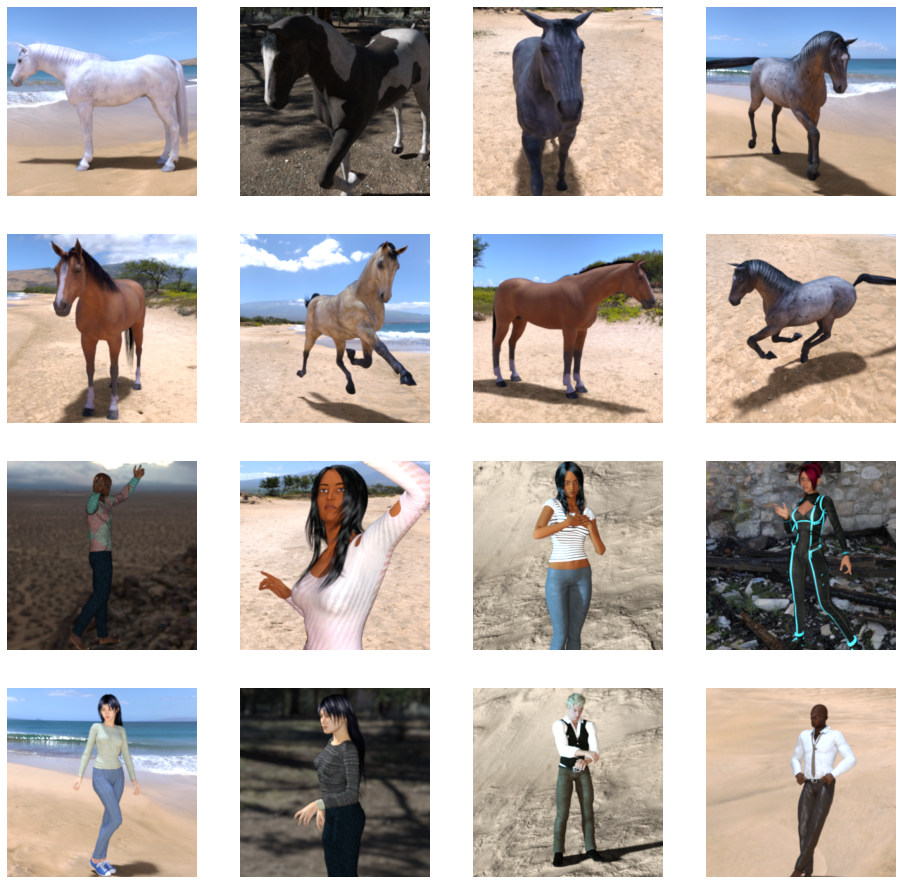

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [5]:
import tensorflow as tf

#creating the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid') #two classes, sigmoid -> binary 
])

#Inspect the layers of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

In [6]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=0.001),
             metrics=['acc'])

In [7]:
#Image generator: labels the images accordingly to the folder.
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#for training
train_datagen = ImageDataGenerator(rescale=1./255) #normalize the data
train_generator = train_datagen.flow_from_directory('/tmp/horse-or-human/', #directory
                                                  target_size=(300,300), #resize
                                                  batch_size = 128, #batch more efficient
                                                  class_mode = 'binary') 


Found 1027 images belonging to 2 classes.


In [9]:
history = model.fit_generator(train_generator, #from training directory
                             steps_per_epoch = 8, #number_images/batch_size
                             epochs =5,
                             verbose=1) #how much to display

8/8 [==============================] - 39s 5s/step - loss: 0.0011 - acc: 1.0000


In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np
import glob

keys = glob.glob("test_images/*.jpeg")

for fn in keys:
    # predicting images
    img = image.load_img(fn, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + ' is a human')
    else:
        print(fn + 'is a horse')

[1.]
test_images/persona2.jpeg is a human
[0.]
test_images/caballo1.jpegis a horse
[0.]
test_images/caballo2.jpegis a horse
[1.]
test_images/persona1.jpeg is a human


<ipython-input-17-767b52538658>:42: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


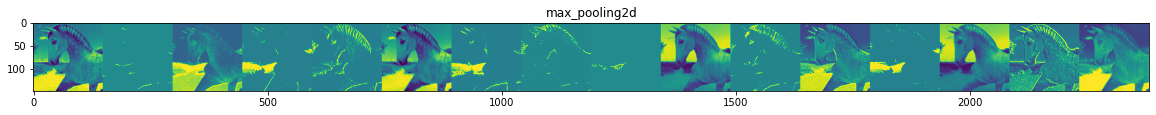

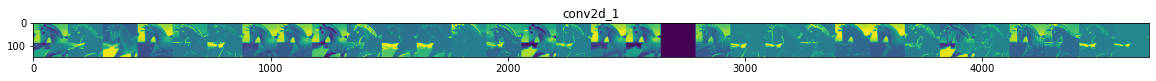

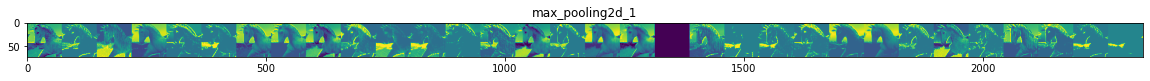

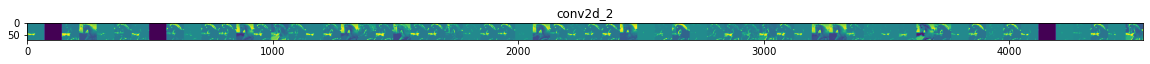

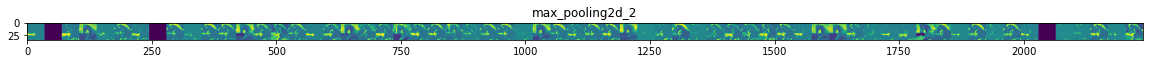

In [17]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')